In [1]:
import os
import pickle
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import Xception
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

dataset_code = 'A'
model_name = 'Xception'
data_saved_dir = r'D:\My Code\Classification\pickle_data'
train_data_path = os.path.join(data_saved_dir, f'{dataset_code}_training.pkl')
train_images, train_labels = load_pickle(train_data_path)

val_data_path = os.path.join(data_saved_dir, 'validation_data.pkl')
val_images, val_labels = load_pickle(val_data_path)

In [3]:
Xception_model = Xception(include_top=False, weights='imagenet', input_shape=(256, 256, 3))

model = Sequential()
model.add(Xception_model)

for layer in model.layers:
    layer.trainable = False

model.add(Flatten())
model.add(Dense(units=2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 10s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 2048)              268437504 
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 289,301,033
Trainable params: 268,439,553
Non-trainable params: 20,861,480
_________________________________

In [4]:
history = model.fit(train_images, train_labels, epochs = 50, batch_size = 32, validation_data = (val_images, val_labels))

Epoch 1/50
35/35 [==============================] - 11s 190ms/step - loss: 7.5824 - accuracy: 0.8217 - val_loss: 3.1591 - val_accuracy: 0.9247
Epoch 2/50
35/35 [==============================] - 5s 135ms/step - loss: 1.7017 - accuracy: 0.9435 - val_loss: 2.3494 - val_accuracy: 0.9331
Epoch 3/50
35/35 [==============================] - 5s 135ms/step - loss: 1.1133 - accuracy: 0.9525 - val_loss: 3.1557 - val_accuracy: 0.9372
Epoch 4/50
35/35 [==============================] - 5s 134ms/step - loss: 0.3838 - accuracy: 0.9794 - val_loss: 2.1649 - val_accuracy: 0.9331
Epoch 5/50
35/35 [==============================] - 5s 135ms/step - loss: 0.3719 - accuracy: 0.9812 - val_loss: 2.0234 - val_accuracy: 0.9247
Epoch 6/50
35/35 [==============================] - 5s 136ms/step - loss: 0.3382 - accuracy: 0.9830 - val_loss: 1.9218 - val_accuracy: 0.9456
Epoch 7/50
35/35 [==============================] - 5s 136ms/step - loss: 0.2149 - accuracy: 0.9848 - val_loss: 2.4641 - val_accuracy: 0.9414
Epoch

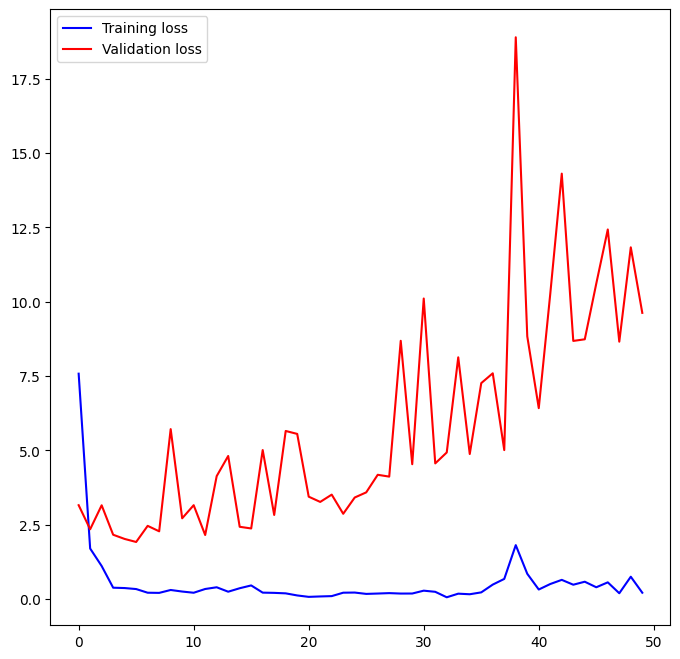

<Figure size 640x480 with 0 Axes>

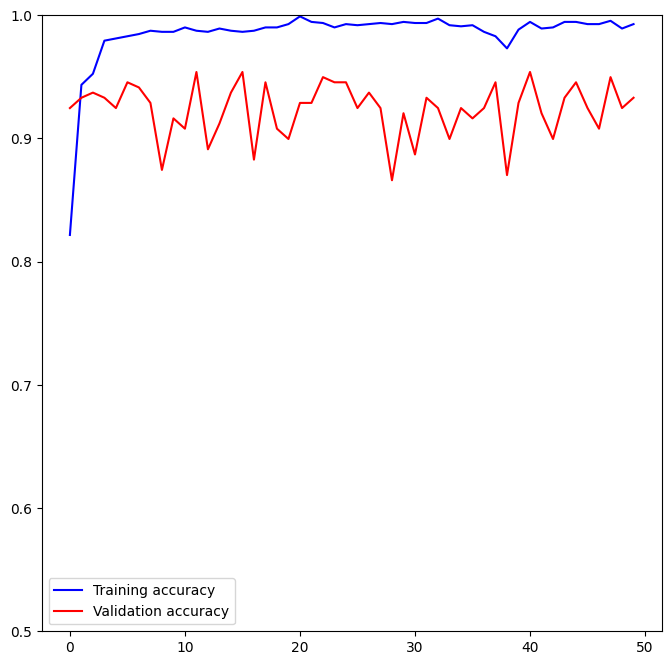

In [5]:
plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], color='b', label="Training loss")
plt.plot(history.history['val_loss'], color='r', label="Validation loss")
plt.legend()
plt.show()

plt.figure()

plt.figure(figsize=(8,8))
plt.plot(history.history['accuracy'], color='b', label="Training accuracy")
plt.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
plt.legend()
plt.ylim(0.5, 1)
plt.show()

8/8 [==============================] - 2s 131ms/step


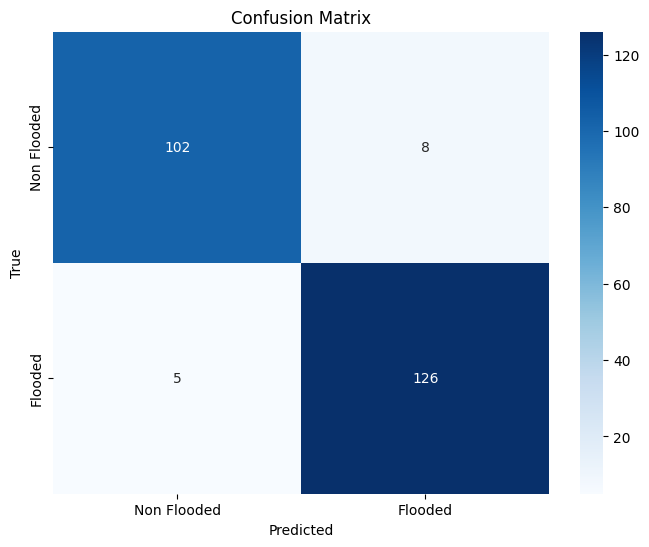

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       110
           1       0.94      0.96      0.95       131

    accuracy                           0.95       241
   macro avg       0.95      0.94      0.95       241
weighted avg       0.95      0.95      0.95       241



In [6]:
test_data_path = os.path.join(data_saved_dir, 'test_data.pkl')
test_images, test_labels = load_pickle(test_data_path)

predictions = model.predict(test_images)

predicted_labels = (predictions > 0.5).astype(int)

conf_matrix = confusion_matrix(test_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non Flooded', 'Flooded'], yticklabels=['Non Flooded', 'Flooded'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print("Classification Report:")
print(classification_report(test_labels, predicted_labels))

In [7]:
model_saved = r'D:\My Code\Classification\models'
model.save(os.path.join(model_saved, f'{dataset_code}_{model_name} (256X256).h5'))